* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

## Подготовка

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Простой конфиг (для хранения параметров, можете использовать и модифицировать)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 25
config.noise_size = 50
config.print_freq = 1000
config.weight_clip = 0.01
config.class_size = 10
config.embedding_dim = 5

### Создаем dataloader

In [4]:
train = torchvision.datasets.FashionMNIST("data/fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 26421880/26421880 [00:09<00:00, 2903472.21it/s]


Extracting data/fashion_mnist\FashionMNIST\raw\train-images-idx3-ubyte.gz to data/fashion_mnist\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 665241.99it/s]


Extracting data/fashion_mnist\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data/fashion_mnist\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3806729.82it/s]


Extracting data/fashion_mnist\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data/fashion_mnist\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5372549.64it/s]

Extracting data/fashion_mnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data/fashion_mnist\FashionMNIST\raw



In [5]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)
len(dataloader)

3750

In [6]:
image, label = next(iter(dataloader))
image.size()

torch.Size([16, 1, 28, 28])

## GAN

### Создаем модель GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

### Оптимизатор и функция потерь

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = generator.to(device)
discrimi8nator = discriminator.to(device)
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Для оптимизации процесса обучения можно заранее определить переменные и заполнять их значения новыми данными

In [ ]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device))
# fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size, device=device))
real_label = 1
fake_label = 0

### GAN обучение

In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(device)
        output = discriminator(input_data).view(-1)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 1000 errD_x: 0.29 errD_z: 0.18 errG: 2.20
Epoch:1 Iter: 2000 errD_x: 0.04 errD_z: 0.14 errG: 2.82
Epoch:1 Iter: 3000 errD_x: 0.02 errD_z: 0.04 errG: 5.31
Epoch:2 Iter: 1000 errD_x: 0.00 errD_z: 0.07 errG: 4.08
Epoch:2 Iter: 2000 errD_x: 0.38 errD_z: 0.05 errG: 3.68
Epoch:2 Iter: 3000 errD_x: 0.01 errD_z: 0.07 errG: 3.55
Epoch:3 Iter: 1000 errD_x: 0.06 errD_z: 0.10 errG: 3.63
Epoch:3 Iter: 2000 errD_x: 0.05 errD_z: 0.11 errG: 2.80
Epoch:3 Iter: 3000 errD_x: 0.06 errD_z: 0.04 errG: 3.98
Epoch:4 Iter: 1000 errD_x: 0.24 errD_z: 0.23 errG: 1.95
Epoch:4 Iter: 2000 errD_x: 0.50 errD_z: 0.22 errG: 3.12
Epoch:4 Iter: 3000 errD_x: 0.05 errD_z: 0.05 errG: 4.68
Epoch:5 Iter: 1000 errD_x: 0.41 errD_z: 0.07 errG: 2.43
Epoch:5 Iter: 2000 errD_x: 0.35 errD_z: 0.10 errG: 2.86
Epoch:5 Iter: 3000 errD_x: 0.39 errD_z: 0.04 errG: 3.17
Epoch:6 Iter: 1000 errD_x: 0.32 errD_z: 0.01 errG: 4.79
Epoch:6 Iter: 2000 errD_x: 0.04 errD_z: 0.25 errG: 2.30
Epoch:6 Iter: 3000 errD_x: 0.52 errD_z: 0.29 err

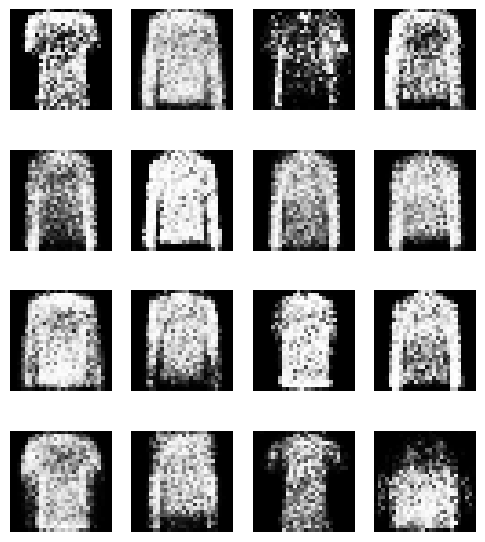

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

## WGAN_clipping

### Создаем модель WGAN_clipping

In [ ]:
class Gen_wgan_clip(nn.Module):
    def __init__(self):
        super(Gen_wgan_clip, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Tanh())

    def forward(self, x):
        return self.model(x)

class Disc_wgan_clip(nn.Module):
    def __init__(self):
        super(Disc_wgan_clip, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
            )

    def forward(self, x):
        return self.model(x)

In [ ]:
gen_wgan_clip = Gen_wgan_clip()
critic_clip = Disc_wgan_clip()

### Оптимизатор и функция потерь

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gen_wgan_clip = gen_wgan_clip.to(device)
critic_clip = critic_clip.to(device)
optim_G_wgan_clip = optim.RMSprop(params=gen_wgan_clip.parameters(), lr=0.0001)
optim_C_clip = optim.RMSprop(params=critic_clip.parameters(), lr=0.0001)

criterion = nn.BCEWithLogitsLoss()

### Для оптимизации процесса обучения можно заранее определить переменные и заполнять их значения новыми данными

In [ ]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device))
label = Variable(torch.FloatTensor(config.batch_size, device=device))
real_label = 1
fake_label = 0

### WGAN clipping обучение

In [ ]:
ERRD_real = np.zeros(config.num_epochs)
ERRD_fake = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage:
        #######
        critic_clip.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(device)
        output = critic_clip(input_data).view(-1)
        errD_real = criterion(output, label)
        ERRD_real[epoch] += errD_real.item()
        errD_real.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = gen_wgan_clip(noise)
        label.data.fill_(fake_label)
        output = critic_clip(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        ERRD_fake[epoch] += errD_fake.item()
        errD_fake.backward()

        optim_C_clip.step()

        for p in critic_clip.parameters():
                p.data.clamp_(-config.weight_clip, config.weight_clip)

        #######
        # Generator stage:
        #######
        gen_wgan_clip.zero_grad()
        label.data.fill_(real_label)
        output = critic_clip(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G_wgan_clip.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{},  Iter:{},  errD_real:{:.2f},  errD_fake:{:.2f},  errG:{:.2f}'.format(
                epoch+1,
                iteration+1,
                errD_real.item(),
                errD_fake.item(),
                errG.item()))

Epoch:1, Iter:1000, errD_real:0.68, errD_fake:0.69, errG:0.70
Epoch:1, Iter:2000, errD_real:0.68, errD_fake:0.69, errG:0.69
Epoch:1, Iter:3000, errD_real:0.69, errD_fake:0.69, errG:0.70
Epoch:2, Iter:1000, errD_real:0.69, errD_fake:0.69, errG:0.70
Epoch:2, Iter:2000, errD_real:0.69, errD_fake:0.70, errG:0.69
Epoch:2, Iter:3000, errD_real:0.69, errD_fake:0.69, errG:0.70
Epoch:3, Iter:1000, errD_real:0.69, errD_fake:0.69, errG:0.70
Epoch:3, Iter:2000, errD_real:0.68, errD_fake:0.70, errG:0.69
Epoch:3, Iter:3000, errD_real:0.69, errD_fake:0.69, errG:0.70
Epoch:4, Iter:1000, errD_real:0.69, errD_fake:0.69, errG:0.69
Epoch:4, Iter:2000, errD_real:0.69, errD_fake:0.69, errG:0.70
Epoch:4, Iter:3000, errD_real:0.69, errD_fake:0.69, errG:0.70
Epoch:5, Iter:1000, errD_real:0.69, errD_fake:0.69, errG:0.70
Epoch:5, Iter:2000, errD_real:0.70, errD_fake:0.69, errG:0.70
Epoch:5, Iter:3000, errD_real:0.69, errD_fake:0.71, errG:0.70
Epoch:6, Iter:1000, errD_real:0.69, errD_fake:0.69, errG:0.70
Epoch:6,

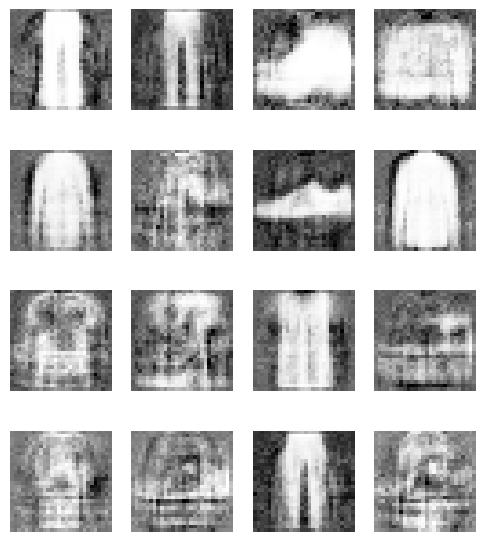

In [ ]:
noise.data.normal_(0, 1)
fake = gen_wgan_clip(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

## WGAN gradient penalty

In [ ]:
class Gen_wgan_gp(nn.Module):
    def __init__(self):
        super(Gen_wgan_gp, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Tanh())

    def forward(self, x):
        return self.model(x)

class Disc_wgan_gp(nn.Module):
    def __init__(self):
        super(Disc_wgan_gp, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
            )

    def forward(self, x):
        return self.model(x)

In [ ]:
gen_wgan_gp = Gen_wgan_gp()
critic_gp = Disc_wgan_gp()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gen_wgan_gp = gen_wgan_gp.to(device)
critic_gp = critic_gp.to(device)
optim_G_wgan_gp = optim.Adam(params=gen_wgan_gp.parameters(), lr=0.0001)
optim_C_gp = optim.Adam(params=critic_gp.parameters(), lr=0.0001)

criterion = nn.BCEWithLogitsLoss()

In [ ]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device))
label = Variable(torch.FloatTensor(config.batch_size, device=device))
real_label = 1
fake_label = 0

In [ ]:
def gradient_penalty( critic, real_image, fake_image, device="cpu"):
    height, width = real_image.shape
    # alpha is selected randomly between 0 and 1
    alpha = torch.rand(config.batch_size,1,1,1).repeat(1, 1, height, width)

    # interpolated image=randomly weighted average between a real and fake image
    interpolatted_image = alpha*real_image + (1-alpha) * fake_image

    # calculate the critic score on the interpolated image
    interpolated_score= critic(interpolatted_image)

    # take the gradient of the score wrt to the interpolated image
    gradient = torch.autograd.grad(
        inputs=interpolatted_image,
        outputs=interpolated_score,
        # retain_graph=True,
        # create_graph=True,
        grad_outputs=torch.ones_like(interpolated_score)
        )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm-1)**2)
    return gradient_penalty

In [ ]:
ERRD_real = np.zeros(config.num_epochs)
ERRD_fake = np.zeros(config.num_epochs)
ERRD = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage:
        #######
        critic_gp.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(device)
        output = critic_gp(input_data).view(-1)
        errD_real = criterion(output, label)
        ERRD_real[epoch] += errD_real.item()
        errD_real.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = gen_wgan_gp(noise)
        label.data.fill_(fake_label)
        output = critic_gp(fake.detach()).view(-1)

        errD_fake = criterion(output, label)
        ERRD_fake[epoch] += errD_fake.item()
        errD_fake.backward()

        gp = gradient_penalty(critic_gp, input_data, fake, device)
        errD = errD_fake - errD_real + gp
        ERRD[epoch] += errD.item()

        optim_C_gp.step()

        #######
        # Generator stage:
        #######
        gen_wgan_gp.zero_grad()
        label.data.fill_(real_label)
        output = critic_gp(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G_wgan_gp.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{},  Iter:{},  errD_real:{:.2f},  errD_fake:{:.2f},  errG:{:.2f}'.format(
                epoch+1,
                iteration+1,
                errD_real.item(),
                errD_fake.item(),
                errG.item()))

Epoch:1, Iter:1000, errD_real:0.14, errD_fake:0.13, errG:2.30
Epoch:1, Iter:2000, errD_real:0.35, errD_fake:0.19, errG:2.06
Epoch:1, Iter:3000, errD_real:0.54, errD_fake:0.30, errG:1.71
Epoch:2, Iter:1000, errD_real:0.37, errD_fake:0.28, errG:1.83
Epoch:2, Iter:2000, errD_real:0.48, errD_fake:0.28, errG:1.67
Epoch:2, Iter:3000, errD_real:0.16, errD_fake:0.20, errG:1.81
Epoch:3, Iter:1000, errD_real:0.24, errD_fake:0.22, errG:2.28
Epoch:3, Iter:2000, errD_real:0.59, errD_fake:0.33, errG:1.75
Epoch:3, Iter:3000, errD_real:0.94, errD_fake:0.18, errG:2.26
Epoch:4, Iter:1000, errD_real:0.61, errD_fake:0.60, errG:1.22
Epoch:4, Iter:2000, errD_real:0.69, errD_fake:0.33, errG:1.72
Epoch:4, Iter:3000, errD_real:0.79, errD_fake:0.37, errG:1.84
Epoch:5, Iter:1000, errD_real:0.50, errD_fake:0.56, errG:1.71
Epoch:5, Iter:2000, errD_real:0.28, errD_fake:0.18, errG:2.15
Epoch:5, Iter:3000, errD_real:0.30, errD_fake:0.28, errG:1.95
Epoch:6, Iter:1000, errD_real:0.49, errD_fake:0.36, errG:1.75
Epoch:6,

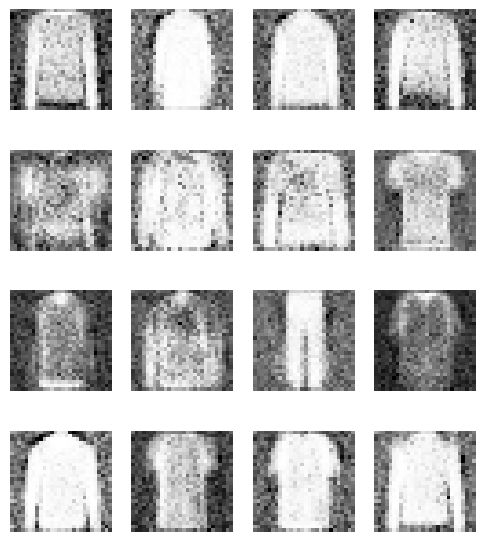

In [ ]:
noise.data.normal_(0, 1)
fake = gen_wgan_gp(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

## Conditinal WGAN

In [8]:
class Gen_cond_wgan(nn.Module):
    def __init__(self):
        super(Gen_cond_wgan, self).__init__()

        self.embedding = nn.Embedding(config.class_size, config.embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(config.noise_size + config.embedding_dim, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Tanh())

    def forward(self, input, label):
        #embed label
        label = self.embedding(label)

        #concatenate latent vector (input) and label
        x = torch.cat([input, label], 1)

        result = self.model(x)
        result = result.view(-1, 1, 28, 28)
        return result

class Disc_cond_wgan(nn.Module):
    def __init__(self):
        super(Disc_cond_wgan, self).__init__()

        self.embedding = nn.Embedding(config.class_size, config.embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(28*28 + config.embedding_dim, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid()
            )

    def forward(self, input, label):
        #embed label
        label = self.embedding(label)

        #flatten image to 2d tensor
        input = input.view(input.size(0), -1)

        #concatenate image vector and label
        x = torch.cat([input, label], 1)
        result = self.model(x)
        return result

In [7]:
gen_cond_wgan = Gen_cond_wgan()
critic_cond = Disc_cond_wgan()

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gen_cond_wgan = gen_cond_wgan.to(device)
critic_cond = critic_cond.to(device)
optim_G_cond_wgan = optim.Adam(params=gen_cond_wgan.parameters(), lr=0.0001)
optim_C_cond = optim.Adam(params=critic_cond.parameters(), lr=0.0001)

criterion = nn.BCEWithLogitsLoss()

In [14]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device))
label = Variable(torch.FloatTensor(config.batch_size, device=device))
real_label = 1
fake_label = 0

In [10]:
def gradient_penalty(critic, real_samples, fake_samples, labels):
        # Random weight term for interpolation between real and fake samples
        alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(device)
        # Get random interpolation between real and fake samples
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        d_interpolates = critic(interpolates, labels)
        fake = torch.Tensor(real_samples.shape[0], 1).fill_(1.0).to(device)
        fake.requires_grad = False
        # Get gradient w.r.t. interpolates
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )
        gradients = gradients[0].view(gradients[0].size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

In [11]:
for epoch in range(config.num_epochs):
    gen_loss_list = []
    dis_loss_list = []
    was_loss_list = []
    gen_loss = 0
    dis_loss = 0
    for images, labels in dataloader:
        b_size = len(images)
        #train Discriminator with Wasserstein Loss
        critic_cond.zero_grad()

        #fake loss
        noise.data.normal_(0, 1)
        fake_images = gen_cond_wgan(noise, labels.to(device))
        fake_pred = critic_cond(fake_images, labels.to(device))
        d_loss_fake = torch.mean(fake_pred)

        #real loss
        real_pred = critic_cond(images.to(device), labels.to(device))
        d_loss_real = -torch.mean(real_pred)

        gp = gradient_penalty(critic_cond, images.to(device), fake_images, labels.to(device))

        d_loss = d_loss_fake - d_loss_real
        was_loss = (d_loss_fake + d_loss_real) + gp
        was_loss.backward()
        optim_C_cond.step()

        dis_loss += d_loss.item()/b_size

        #train Generator
        gen_cond_wgan.zero_grad()

        noise.data.normal_(0, 1)
        fake_images = gen_cond_wgan(noise, labels.to(device))
        fake_pred = critic_cond(fake_images, labels.to(device))
        g_loss = -torch.mean(fake_pred)
        g_loss.backward()
        optim_G_cond_wgan.step()

        gen_loss += g_loss.item()/b_size

    print('Epoch {},    Gen Loss: {:.4f},   Dis Loss: {:.4f},   Was Loss: {:.4f}'.format(epoch+1, gen_loss, dis_loss, was_loss))
    gen_loss_list.append(gen_loss)
    dis_loss_list.append(dis_loss)
    was_loss_list.append(was_loss)


Epoch 0,    Gen Loss: -46.9270,   Dis Loss: 234.2795,   Was Loss: -0.5140
Epoch 1,    Gen Loss: -46.9992,   Dis Loss: 231.8232,   Was Loss: -0.3139
Epoch 2,    Gen Loss: -50.9929,   Dis Loss: 230.9479,   Was Loss: -0.3305
Epoch 3,    Gen Loss: -60.6123,   Dis Loss: 230.4598,   Was Loss: -0.2567
Epoch 4,    Gen Loss: -62.3577,   Dis Loss: 222.7550,   Was Loss: -0.2497
Epoch 5,    Gen Loss: -71.1157,   Dis Loss: 223.5363,   Was Loss: -0.1956
Epoch 6,    Gen Loss: -76.1021,   Dis Loss: 226.0704,   Was Loss: -0.0390
Epoch 7,    Gen Loss: -81.1751,   Dis Loss: 229.1840,   Was Loss: -0.2241
Epoch 8,    Gen Loss: -85.7856,   Dis Loss: 231.1193,   Was Loss: -0.2054
Epoch 9,    Gen Loss: -88.2004,   Dis Loss: 229.3983,   Was Loss: -0.2390
Epoch 10,    Gen Loss: -88.2269,   Dis Loss: 230.0510,   Was Loss: -0.1357
Epoch 11,    Gen Loss: -91.0042,   Dis Loss: 232.7186,   Was Loss: -0.0260
Epoch 12,    Gen Loss: -91.0633,   Dis Loss: 233.5027,   Was Loss: -0.0972
Epoch 13,    Gen Loss: -91.7198,   

In [11]:
# Создаем словарь, для удобства проверки качества классификации
glossary = {0: 'Футболка', 1: 'Брюки', 2: 'Свитер', 3: 'Платье',
            4: 'Пальто', 5: 'Сандалия', 6: 'Рубашка', 7: 'Кроссовок',
            8: 'Сумка', 9: 'Сапог'}

In [ ]:
# Посмотрим примеры картинок для классификации
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(str(y_train[i]) + ' - ' + glossary[y_train[i]])
plt.show()

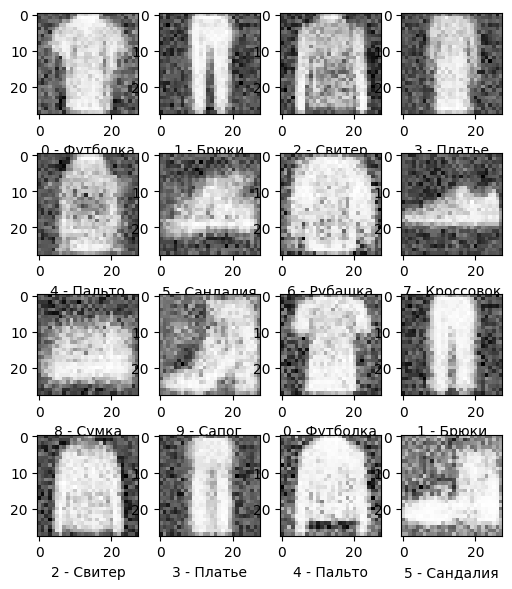

In [18]:
noise.data.normal_(0, 1)
labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5])
labels_tensor = torch.LongTensor(labels).to(device)
fake = gen_cond_wgan(noise, labels_tensor)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.xlabel(str(labels[i]) + ' - ' + glossary[labels[i]])

In [47]:
torch.save(gen_cond_wgan, 'CondGen')
torch.save(critic_cond, 'CondCritic')

In [9]:
gen_cond_wgan = Gen_cond_wgan()
gen_cond_wgan.load_state_dict(torch.load('models/CondGen'))

critic_cond = Disc_cond_wgan()
critic_cond.load_state_dict(torch.load('models/CondCritic'))

C:\Users\smart\AppData\Local\Temp\ipykernel_20840\4161799510.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_cond_wgan.load_state_dict(torch.load('models/CondGen'))


<All keys matched successfully>